In [1]:
'''importando pacotes essenciais'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Neste exercício, vamos trabalhar com a série de temperatura mínima diária referente à
cidade de Melbourne, Austrália, no período de 1981 a 1990. As observações estão em
graus Celsius e há 3650 amostras no total. Os dados são creditados ao Australian
Bureau of Meteorology. 

In [2]:
#lendo os dados do arquivo csv com o pandas
dataset = pd.read_csv('daily-minimum-temperatures.csv')

#mostrando os ultimos registros
dataset.tail()

,Date,Temp
3645,1990-12-27,14.0
3646,1990-12-28,13.6
3647,1990-12-29,13.5
3648,1990-12-30,15.7
3649,1990-12-31,13.0


In [7]:
#mostrando os primeiros registros
dataset.shape


(3650, 2)

In [26]:
#cria um array numpy com o mesmo shape do pandas
dados = np.ndarray(dataset.shape)
type(dados)

numpy.ndarray

In [29]:
#converte os dados em pandas para numpy
dados = dataset.values
dados.shape

(3650, 2)

In [50]:
#coluna 1
dados[:,[0]]

array([['1981-01-01'],
       ['1981-01-02'],
       ['1981-01-03'],
       ...,
       ['1990-12-29'],
       ['1990-12-30'],
       ['1990-12-31']], dtype=object)

In [49]:
#coluna 2
dados[:,[1]]

array([[20.7],
       [17.9],
       [18.8],
       ...,
       [13.5],
       [15.7],
       [13.0]], dtype=object)

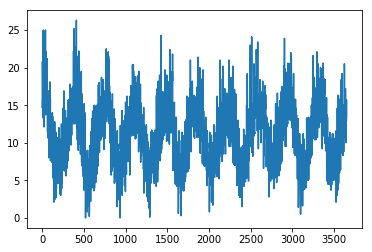

<Figure size 1440x720 with 0 Axes>

In [55]:
#grafico dos dados
plt.plot(dados[:,[1]])
fig = plt.figure(figsize=(20, 10))
plt.show()

In [67]:
#dados sobre a temperatuda
np.mean(dados[:,[1]])

11.177753424657539

In [6]:
'''
plotando um grafico simples

n = np.linspace(0, 2, 100)

plt.plot(n, n, label='linear')
plt.plot(n, n**2, label='quadrado')
plt.plot(n, n**3, label='cubico')

plt.xlabel('eixo x')
plt.ylabel('eixo y')

plt.title('plot de funcoes simples')

plt.legend()

plt.show
'''

ValueError: sequence too large; cannot be greater than 32